In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Ensemble Learning to Classify Short Text Interview Exerpts
Authors: Ahmed Z. , Cohen H. and Spence S.

# Introduction

Our challenge is to classify transcribed exerpts from NPR radio interviews according to the occupation of the person who is being interviewed. In our dataset, we had three categories: Musician (music), Author (author) and Filmmaker (movie) in addition to a generic 'Interview' cateogry.

An interesting topic with interview text is that it is short. Unlike with articles from news websites or books, interview text is about an order of magnitude smaller. It is also conversational simillar to Twitter. Techniques developed in this paper have a wide variety of applications where interviews need to be classified for example in the setting of a criminal investigation to aid investigators or automatic detection of topics from interviews of polliticians to aid publishers in filtering.

We developed four approaches. For our baseline algorithm we used a Naive Bayes classifier. For part 2 we developed a K nearest neighbours approach from scratch. For part 3, we developed an eager learner additive model TF-IDF ngram approach from scratch. Finally, we developed a fourth method from scratch where we combined these approaches into a voting system, known in the literature as ensemble learning, whose votes are weighted according to the various true positive rates and confidence rates for each method.

We nicknamed Naive Bayes "Frodo", K Nearest Neighbours "Pippin", additive TF-IDF "Gimli", and the vote system "The Council".

# Data Pre-Processing Methods

Data processing and clean up is arguably just as important as the machine learning itself.

We developed four filters that can be applied to the data. During development of our classification algorithms, we tested on all 16 combinations of those four filters being on or off. For example, the ones and zeroes in the file named "train-0111.csv" correspond to whether each filter is on or off. For "0111":

- 0 `remove_stops=False`: Does not remove stops words like "at" and "the".
- 1 `stem=True`: Words like "running" are stemmed into "run". Used Python's NLTK SnowballStemmer.
- 1 `remove_tokens=True`: Removes all tokens (comma, dash, question mark) but NOT periods.
- 1 `remove_periods=True`: Removes all periods.

We also applied two more filters regardless of filter settings. All characters outside a (generous) whitelist were removed. Finally, all words were set to lowercase, except for unusual capitalization, like capitals not succeeding a period, or many capitals like in acronyms.

Tokens that were not removed were instead replaced by "_comma", "_period", etc. The script "cleaner.py" was used to produce the 16 CSV files.

In [3]:
from cleaner import SnowballStemmer, clean_text
stemmer = SnowballStemmer('english')
text = "We are recording the coolest interview... with Bob Joe."
print(clean_text(text,stemmer=False,remove_stops=False,remove_tokens=False,remove_periods=False))
print(clean_text(text,stemmer=stemmer,remove_stops=True,remove_tokens=True,remove_periods=True))

we are recording the coolest interview _ellipses with Bob Joe _period
record coolest interview Bob Joe


Entry 27313 was removed from the dataset as it was an empty string, possibly a result of incorrect transcribing of the dataset. As was dicussed in the class forum, it was disregarded.

## Feature Construction: n-grams

One major feature in most of our algorithms was the extensive use of ngrams. The Gimli and Pippin approaches especially, when examining text, extract from the text all permutations of 1-grams, 2-grams, 3-grams, etc, up to some limit (usually  4). These features were boolean (for Pippin) or a count (for Gimli) depending on our approach. One major advantage to this multi-ngram approach is it has the advantages of a bag of words (reduced dimensionality), except some very local word orderings are still taken into account.

In [2]:
from utilities import get_cumulative_ngrams, get_ngrams
words=("I","am","a","sentence","_period")
print(get_cumulative_ngrams(words,3))

[('I', 'am', 'a'), ('am', 'a', 'sentence'), ('a', 'sentence', '_period'), ('I', 'am'), ('am', 'a'), ('a', 'sentence'), ('sentence', '_period'), ('I',), ('am',), ('a',), ('sentence',), ('_period',)]


Another feature was punctuation. Depending on the filters used, all punctuation was removed, or all punctuation except periods. This was naturally integrated into the ngram system above.

##  Feature Selection: $\chi^2$ $k$-best
To increase the speed of the Naive Bayes Classifier, we picked the top $k$ most correlated (with the category) words from our corpus to use as our feature set using the $\chi^2$ test. (Implemented using [`scikit.learn feature_selection`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html))

# Algorithm Selection

## Part 1 - Naïve Bayes

The Bernoulli Naïve Bayes algorithm was selected as a Baseline algorithm. To account for the multi-class nature of the data, we used a "one vs all" implementation of the classifier that couples multiple single class classifier and taking an argmax over the probabilities of the class occuring.

We use rule $Y_{prediction} = \underset{y_i\in\{0,1\}} {\mathrm{argmax}} ~P(Y=y_i)\cdot\prod_{j=1}^m P(x_j~|Y=y_i)$, where $x_j$ is an indicator random variable for the presence of word $j$ from a word vector, $X=<x_1, \ldots, x_m>$.

By the Naïve Bayes assumption, all features are independent of each other which greatly simplifies the joint probability distribution of obtaining a vector of features $X$ given a class $Y=y_i$: $P(<x_1, \ldots, x_m>|Y=y_i) = \prod_{j=1}^m P(x_j~|~Y=y_i)$. Now the quantities $P(Y=y_i)$ and $P(x_j~|~Y=y_i)$ can be estimated by counting frequencies in our dataset.

We also implemented Laplace smoothing which accounted for unobserved data. Code can be found in `SimpleNB.py`.

### Multinomial Naïve Bayes

As required by our challenge guidelines, we were requried to use a more advanced algorithm using an exisiting library like `scikit learn`. We used `scikitlearn.svm.SCV` at first however, the classifier was very slow to train (because Support Vector Machines are inherently two class) and we quickly abandoned the idea. Instead we used `scikitlearn.naive_bayes.MultinomialNB` to implemented a Multinomial Naive Bayes that instead of indicator word vectors we had frequency vectors (counts for each word).

Code can be found in `quickMNB.py`.

## Part 2 - KNN

The "Pippin" algorithm is a k nearest neighbours approach. There is some preprocessing of training data, but most of the work is done after each categorization query is made, so this is a lazy learning method. The order of ngrams is not used, so it is also a bag of words. A typical use might look like this:

> python3 main.py pippin clean/train-1100.csv clean/test-1100.csv --validate --k=10 --ngram-max=3

This will train with the first csv. After everything is done, it will save a predictions CSV using the second csv as its test set. It will "validate" meaning it will take a fraction of the training set (default 80% used for training) and apply validation on it (also showing a confusion matrix for each category). The k value is how many nearest neighbours to take into account for the vote. The ngram-max value is the largest ngrams to take into account, as explained in the feature selection section of our report above.

#### Training Phase

We build a dictionary whose keys are ngrams, and whose values are the set of all ids containing this ngram. For example:

> { ("I","am"):{34,63,22}, ("Jimmy"):{12,378}   ...   }

In this example we've found the 1-gram "Jimmy" in the training set for id 12 and id 378.

In the classificiation phase, we take the text we wish to classify and break it into all its ngrams with get_cumulative_ngrams. We then search our dictionary - for every id belonging to that ngram, we add a vote. The "nearest neighbour" aspect is whichever id has the most points, and thus considered closest.

After finding k nearest neighbours, we take the most commonly occuring category and return that as our prediction.

Code can be found in `pippin.py`

## Part 3 - Weighted Voting

### Early Attempt - Additive TF-IDF

Surprisingly, our very early attempt an algorithm nicknamed "Gimli" was at the top of the leaderboard for two weeks. However, it didn't seem sufficiently interesting or complex for the part 3 "advanced" algorithm. So we combined all algorithms into a weighted voting system (explained in the next section). But here is the Gimli algorithm.

Gimli is an eager learner, additive model that uses bags of words (or bags of ngrams), vote normalization, and TF-IDF (term frequency, inverse document frequency). We descibe the algorithm in high detail as we did not find work that detailed this in popular literature.

Consider a training dataset $D$ containing $N$ documents that are classified into categories $C_1, \ldots, C_k$. The number of documents in each category is given by $N(C_i)~\forall i~\in \{1, \ldots, k\}$. 

A word (or later an n-gram), $w$, is obtained from the corpus of documents. The number of times the word, $w$, appears in each of the categories is given by $N(w \land C_i)$. 

Using the above two estimates we construct a Score, $S(w | C_i) = \frac{N(w \land C_i)}{N(C_i)}$, which is the frequency that word $w$ occurs in $C_i$ and can be interpreted as the estimated probability of observing word $w$ in a given category $C_i$. We can combine these to obtain a scoring vector which scores the word according to each category.

$$S_w = < \frac{N(w \land C_1)}{N(C_1)}, \ldots, \frac{N(w \land C_k)}{N(C_k)}> = < S(w | C_1), \ldots, S(w | C_k) >$$

This can also be thought of the term frequency of $w$ in each category $C_i$.

We can normalize this vector to make it equal to one, but for now let's leave it like this.

We now extend our definition of "word" to include all consequitive 2-grams and 3-grams from a single observation document, $d\in D$

For a document, $d \in D$, the score for $d$ in category $C_i$ is given by a summation of the $n$th power of the score for individual n-grams, $w$ created from $d$: 

$$S(d | C_i) = \sum_{\text{$w \in$ n-grams of $d$}} S(w | C_i)^n$$

The $n$ adds a hyperparameter in our model, which we can tune to improve our prediction accuracy. This will be discussed later.

#### Example
Since we consider this a novel method, here is an example that compliments our problem.

Consider a dataset $D$ which contains interviews of people from two professions: "musician", $M$ and "author", $A$. The score for words like "played" or instruments might be higher in category $M$ than in $A$, while words like "wrote" or "book" might be higher in category $A$ rather than $M$.

Consider the sentence $d=$"I played my guitar all night long" $\in D$, after a bit of transforming (stemming, removing stop words) will obtain "play guitar all night long". We now need to classify if this sentence belongs to category $A$ or $M$.

The score $\mathcal{S}$ for sentence $d$ is given by the summation of individual scores for each category:

$$\mathcal{S}(d) = S_\text{play}+ S_\text{guitar} + S_\text{all} + S_\text{night} + S_\text{long} + S_\text{play guitar} + S_\text{guitar all} + S_\text{all night} + S_\text{night long} + S_\text{play guitar all} + S_\text{guitar all night}+ S_\text{all night long}$$

This is the summation of 2-d vectors, thus our final vector contains the score for class A and class M:

$$\mathcal{S}(d) = < S(d | C_A),~S(d | C_M)> $$

We can note that words like "play", "guitar", "play guitar" will have high scores in their first components, thus we can now use the general decision rule:

$$C_{predicted}\longleftarrow \underset{C_i \in Categories} {\mathrm{argmax}} S(d | C_i)$$

### Weighted Vote System

Once the Frodo, Pippin, and Gimli methods were done, we integrated them into a custom built weighted voting system "Council". The weights took into account the true positive rates for each method for each category, as well as the average confidence each method had for each category. The justification is that if a method tends to have a great true positive rate, we want to increase weight of its vote. Furthermore, if a method tends to be very confident in its ratings for a certain category but it scores poorly, we want to reduce the weight of its vote. This increase and reduction correspond to the multiplcation and division in the following formuala, respectively:

$Predict(t,m) =$ length 4 vector representing the confidence method $m$ has that text $t$ belongs to each four categories.

$Confidence(t,c)=\sum_{m \in \{F,P,G\}} Predict(t,m)*tp_{c,m} * \frac{1}{con_{c,m}}$

Where $con_{c,m}$ is the average confidence from zero to one for category $c$ using method $m$, where $m \in \{Frodo, Pippin, Gimli\}$.

Where $tp_{c,m}$ is the percent of true positives for class $c$ and method $m$ as obtained from a confusion matrix. 

The values for $tp_{c,m}$ were obtained from earlier runs of each method, and hard coded into "Council". The parameters we used and the CSVs chosen for these runs roughly match parameters obtained through testing and validation (explored in later sections of the world). Here is a screenshot of the console output used to define our true positive rates and confidence rates statically:

<img src="screenshot1.png">

# Optimization 

Once each method had processed their training data, we discarded it from memory. After training, the model that each method builds in memory is used for making predictions, not the raw data itself, making this step possible.

# Testing and Validation 

## Confusion Matrix

To test the performance of the implemented Naive Bayes classifier and how it changes with size of the training set, and difference in choice of filters and n-grams we implemented a `ConfusionMatrix` class which uses the following performance metrics recommended by Sokolova and Lapalme (2009):

$$ \text{(average) accuracy} = \frac{1}{k}\frac{ \sum_{c=1}^k tp_c + tn_c }{\sum_{c=1}^k tp_c + fn_c + fp_c + tn_c }$$
$$ \text{precision} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fp_c  }$$
$$ \text{recall} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fn_c }$$

Where $tp_c, fp_c, tn_c, fn_c$ are the true positives, false positive, true negatives and false negatives respectively for class $c$ as obtained from a confusion matrix. 



## Naive Bayes Validation
Here are some plots for test size, n-gram length and cumulative n-gram length for no filter (0000 dataset). We then choose the best few parameters from here to train classifiers for all combination of filters and then pick the best filters.

### Subset of Training Set

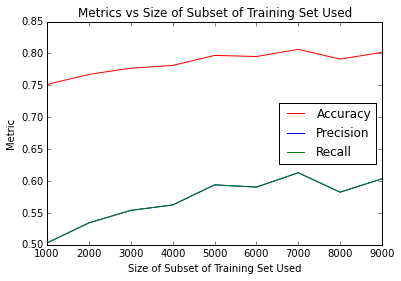

In [2]:
data = pd.read_csv('./performance_test/performance_test_train_size_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Size of Subset of Training Set Used')
plt.ylabel('Metric')
plt.title('Metrics vs Size of Subset of Training Set Used')
plt.legend(loc='best')

From this graph, it seems to show that if your size of subset increases, we increase our accuracy, however, it seems to level off quickly and one must decide if the extra computation time is worth the tiny increase in accuracy. In our predictions, we used a subset of the training size to be $N=10000$. 

### n-gram length

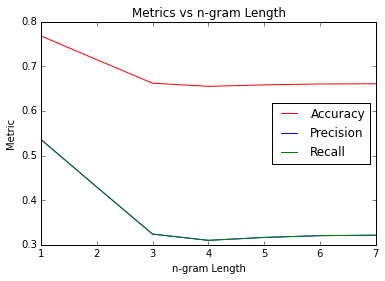

In [3]:
data = pd.read_csv('./performance_test/performance_test_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('n-gram Length')
plt.ylabel('Metric')
plt.title('Metrics vs n-gram Length')
plt.legend(loc='best')

Here n-gram length is the size of our n-grams, where 1, 2, 3 are unigram, bigram and trigrams respectively. Here we clearly see that increasing the size of our n-gram without leaving the previous n-grams (as would in the cumulative n-grams) decreases our accuracy.

Thus we selected n-gram length to be equal to 1.

### `cumulative_ngram` length

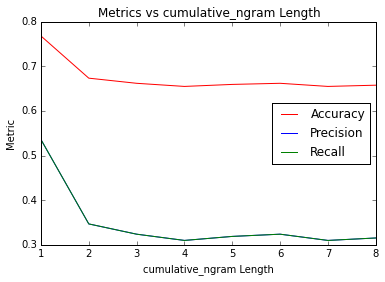

In [4]:
data = pd.read_csv('./performance_test/performance_test_cumulative_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('cumulative_ngram Length')
plt.ylabel('Metric')
plt.title('Metrics vs cumulative_ngram Length')
plt.legend(loc='best')

In the cumulative ngrams, having both unigrams and bigrams or unigrams, bigrams and trigrams doesn't increase our accuracy. Therefore we can safely use only unigrams in our further predictions using Naive Bayes. 

### Data filtering methods

Next, we wanted to discover the effects of how our pre-processing filters described [above](#Data-Pre-Processing-Methods)

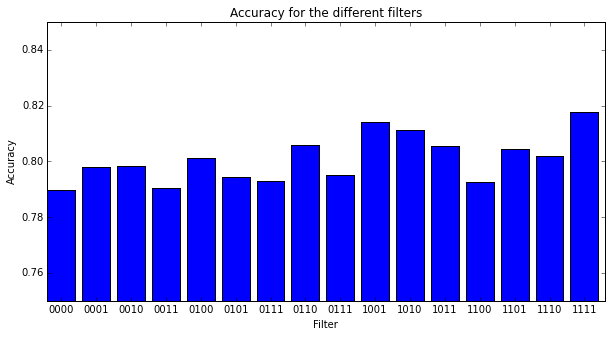

In [4]:
df = pd.read_csv('./performance_test/performance_test_ngram12_learn_codes_0000.csv')
labels = list(map(str, df['learn_code']))
labels[:9] = ['0000', '0001', '0010', '0011', '0100', '0101', '0111', '0110', '0111']
index = np.arange(len(labels))
accuracy = df['accuracy']
plt.figure(figsize=(10,5))
plt.bar(index, accuracy)
# ax = plt.gca()
plt.xticks(index+0.4, labels)
plt.title('Accuracy for the different filters')
plt.ylim([0.75,0.85])
plt.xlabel('Filter')
plt.ylabel('Accuracy')
plt.show()

It turns out stemming, removing stop words and removing all tokens seemed to give us the purest data set which give us the best accuracy on the validation set. Thus in our final predictions, we use filters of 1111.

### k-best in the $\chi^2$ test

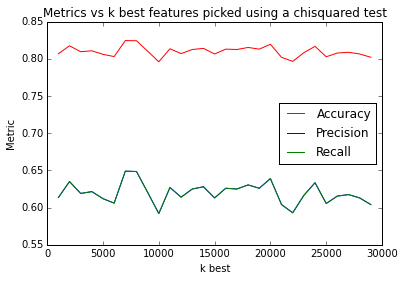

In [2]:
data = pd.read_csv('./performance_test/performance_testchi2_1111.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('k best')
plt.ylabel('Metric')
plt.title('Metrics vs k best features picked using a chisquared test')
plt.legend(loc='best')

From here, we see that increasing k, didn't increase our accuracy by a large amount. Due to the increase speed of using 10,000 features rather than 30,000 features we picked our feature set size to be $M=10000$


## K Nearest Neighbours Validation (Pippin)

The best approach for Pippin involved deciding on a few parameters: ngram_max, filters, and of course, how large to set k. We assumed these parameters are generally independent of each other. A bit of a simplification, but it greatly reduces the complexity of searching this space.

#### Ngram Max

This parameter is the maximum length of ngrams we split the text into.

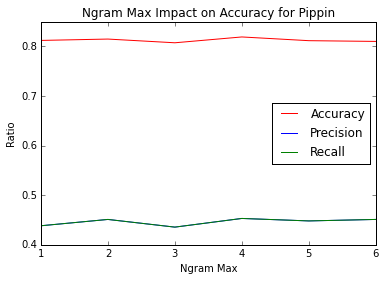

In [20]:
data = pd.read_csv('../chart_data/pippin_ngram_max.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Ngram Max')
plt.ylabel('Ratio')
plt.title('Ngram Max Impact on Accuracy for Pippin')
plt.legend(loc='best')

Like Gimli and Frodo, ngram_max surprisingly had little impact on accuracy.

#### K

And of course, we evaluated different values for k, which is how many closest neighbours get a vote on the category:

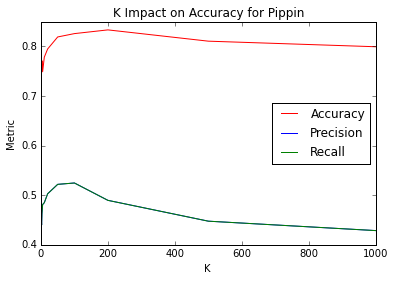

In [17]:
data = pd.read_csv('../chart_data/pippin_k.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('K')
plt.ylabel('Metric')
plt.title('K Impact on Accuracy for Pippin')
plt.legend(loc='best')

Here it looks as though k=200 is the best value. Well in truth, this graph was generated with culled data because Pippin is actually our slowest algorithm. We actually determined earlier in its development that k=500 was a good number, but running the tests again, and many tests to make a smooth graph, is just going to take too long! We used k=500 for Pippin.

## Additive TF-IDF Validation (Gimli)

The best approach for Gimli involved deciding on a few parameters: ngram_max, score_exponent, filters, and filter_threshold.

#### Ngram Max
This parameter is the maximum length of ngrams we split the text into.

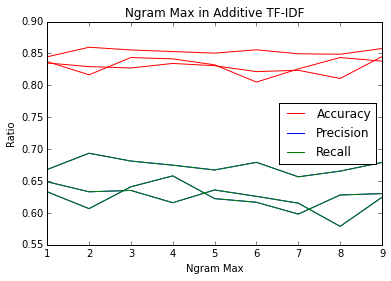

In [13]:
data = pd.read_csv('../chart_data/gimli_ngram_max_all.csv').values
for i in range(3):
    label='Accuracy' if not i else ""
    plt.plot(data[:,0], data[:,i+1], 'r', label=label)
for i in range(3):
    label='Precision' if not i else ""
    plt.plot(data[:,0], data[:,i+4], 'b', label=label)
for i in range(3):
    label='Recall' if not i else ""
    plt.plot(data[:,0], data[:,i+7], 'g', label=label)
plt.xlabel('Ngram Max')
plt.ylabel('Ratio')
plt.title('Ngram Max in Additive TF-IDF')
plt.legend(loc='best')

We used multiple runs to average out random noise. We concluded that changing ngram_max had little impact, however in earlier tests ngram_max=3 was slightly better, so Gimli just stuck with that. Gimli trains and classifies fast so this parameter surprinsingly had little impact.

#### Data filtering methods

Like before, we wanted to know the effects of our data filtering methods.

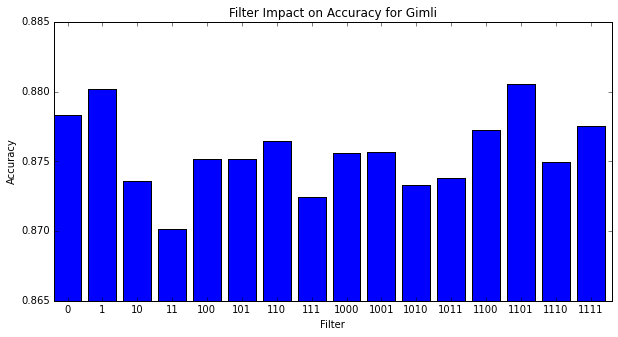

In [11]:
df = pd.read_csv('../chart_data/gimli_16_csv.csv')
labels = list(map(str, df['learn_code']))
#labels[:9] = ['0000', '0001', '0010', '0011', '0100', '0101', '0111', '0110', '0111']
index = np.arange(len(labels))
accuracy = df['accuracy']
plt.figure(figsize=(10,5))
plt.bar(index, accuracy)
# ax = plt.gca()
plt.xticks(index+0.4, labels)
plt.title('Filter Impact on Accuracy for Gimli')
plt.ylim([0.865,0.885])
plt.xlabel('Filter')
plt.ylabel('Accuracy')
plt.show()

It appeared that for Gimli, the filters had hardly any impact at all. We used the full filter 1111 for simplicity, since Naive Bayes started using it too.

#### Filter Threshold

In Gimli (as well as Pippin) there is an option to discard ngrams from the training data if their total count for all training data is below some threshold.

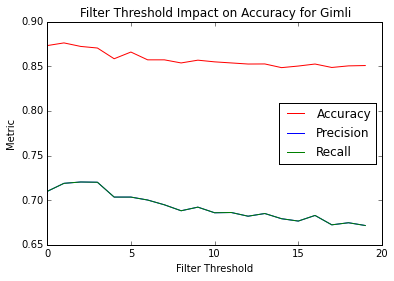

In [15]:
data = pd.read_csv('../chart_data/gimli_threshold.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Filter Threshold')
plt.ylabel('Metric')
plt.title('Filter Threshold Impact on Accuracy for Gimli')
plt.legend(loc='best')

It appeared that the filter threshold gradually reduces performance pretty consistently. However there is an appreciable bump at 1 and 2, and 1 dramatically improves performance (many, many ngrams are only found once in all the training data). So in future runs Gimli had a filter threshold of 1.

#### Score Exponent

In order to lend more weight to scores close to 1, and reduce the weight of scores close to zero, we tried raising these values to an exponent:

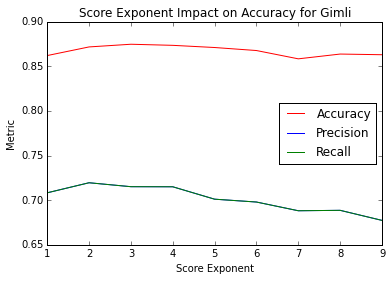

In [16]:
data = pd.read_csv('../chart_data/gimli_score_exponent.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Score Exponent')
plt.ylabel('Metric')
plt.title('Score Exponent Impact on Accuracy for Gimli')
plt.legend(loc='best')

There is a slight improvement in accuracy for exponent 3, so Gimli used that value for the parameter.

Overall, we found that tweaking the parameters of Gimli did not improve its performance very much beyond its first performance.

# Pros and Cons of Approach and Methodology

## Selecting the $k$-best features via the $\chi^2$ test
Scoring features according to the $\chi^2$ test has the fantastic advantage of reducing the size of your feature space. However, we score each feature independently of the other. It could be plausible to obtain the $k$ most highly intercorrelated features which looses its predicting power (and violates Naive Bayes Assumption). However, in our valdiations we find that regardless of the $k$ we select (above a certain threshold) we get almost simillar accuracy as training with all $M>30000$ features.

## Ngrams
The get_cumulative_ngrams seemed fairly successful in some classifiers. It takes advantage of the feature dimensionality reduction aspects of bags of words, but with some improvements. A length four ngram for example maintains the ordering of those four words. It is just very localized, but that isn't much of a drawback since there usually isn't a ton of semantic meaning packed into words being twenty words apart.

## Pippin and KNN
Pippin was a lazy learner and it showed. Training Pippin and constructing its ngram id counter was fast, but each prediction task took significantly longer than our better approaches. On a core i5 laptop it classified about ten pieces of text a second. This is partly due to our simple implementation, as finding the nearest neighbours could surely be heuristically accelerated significantly. We merely built a gigantic list of distances to all neighbours and chose the top k neighbours.

## Lowercase and Uppercase
We felt that some information is lost if we blindly set all words to lowercase. Example: "apple" and "Apple". However the way we set most words to lowercase while maintaining case on special words was flawed: if a sentence starts with "Stuart" our naive, non-semantic approach did not recognize that it should remain capitalized.

## Additive Model
The additive model used by Gimli significantly reduces the curse of dimensionality. This was a big help given text analysis through ngrams is a very high dimensional problems. Unfortunately, we inevitably had high collinearity as well, meaning two ngrams like "piano" and "violin" operate independently even though they should not because they communicate similar importance for our classifier. 

# Statement of Contributions

## Stuart
Stuart developed KNN (Pippin), additive TF-IDF (Gimli), the weighted vote system (Council of Elrond), and their validation code, as well as the data clean up scripts. Also wrote the sections of the report for these and other sections (though Zafarli very helpfully rewrote the Gimli section to be more mathematical and formal).

## Zafarali

Zafarali implemented a Multiclass (one-vs-all) Bernoulli Naive Bayes as seen in class and used scikitlearn to create a multiclass version. Converted the description of Gimli into mathematical formulation. Created validation tests for his classifiers and implemented the Confusion Matrix based on published literature. He also contributed to approximately 50% of the report.

## Hannah
Unfortunately, Hannah was hospitalized and this prevented her from significantly contributing.

We	hereby	state	that	all	the	work presented	in this	report	is	that	of	the	authors

## References
*Marina Sokolova and Guy Lapalme*. A systematic analysis of performance measures for classification tasks, Information Processing and Management 2009
[pdf](http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf)

*Xinruo Sun, Haofen Wang and Yong Yu*. Towards effective short text deep classification, ACM 2011 [link](http://dl.acm.org/citation.cfm?doid=2009916.2010090)

